## Potted grapevine phyllosphere microbiome 16S rRNA gene analysis
## QIIME2 Code

#### Brady L. Welsh, May 2023
  

### First, load and import data into QIIME2.

In [ ]:
conda activate qiime2-2021.8

In [ ]:
cd reads

In [ ]:
qiime tools import \
	--type 'SampleData[PairedEndSequencesWithQuality]' \
	--input-path manifest.tsv \
	--input-format PairedEndFastqManifestPhred33V2 \
	--output-path 16S-demux.qza

### Note, you'll need to adjust the absolute filepaths in the 'manifest.txt' file to match your system.

In [ ]:
qiime demux summarize \
    --i-data 16S-demux.qza \
    --o-visualization 16S-demux.qzv

Quality Plots:

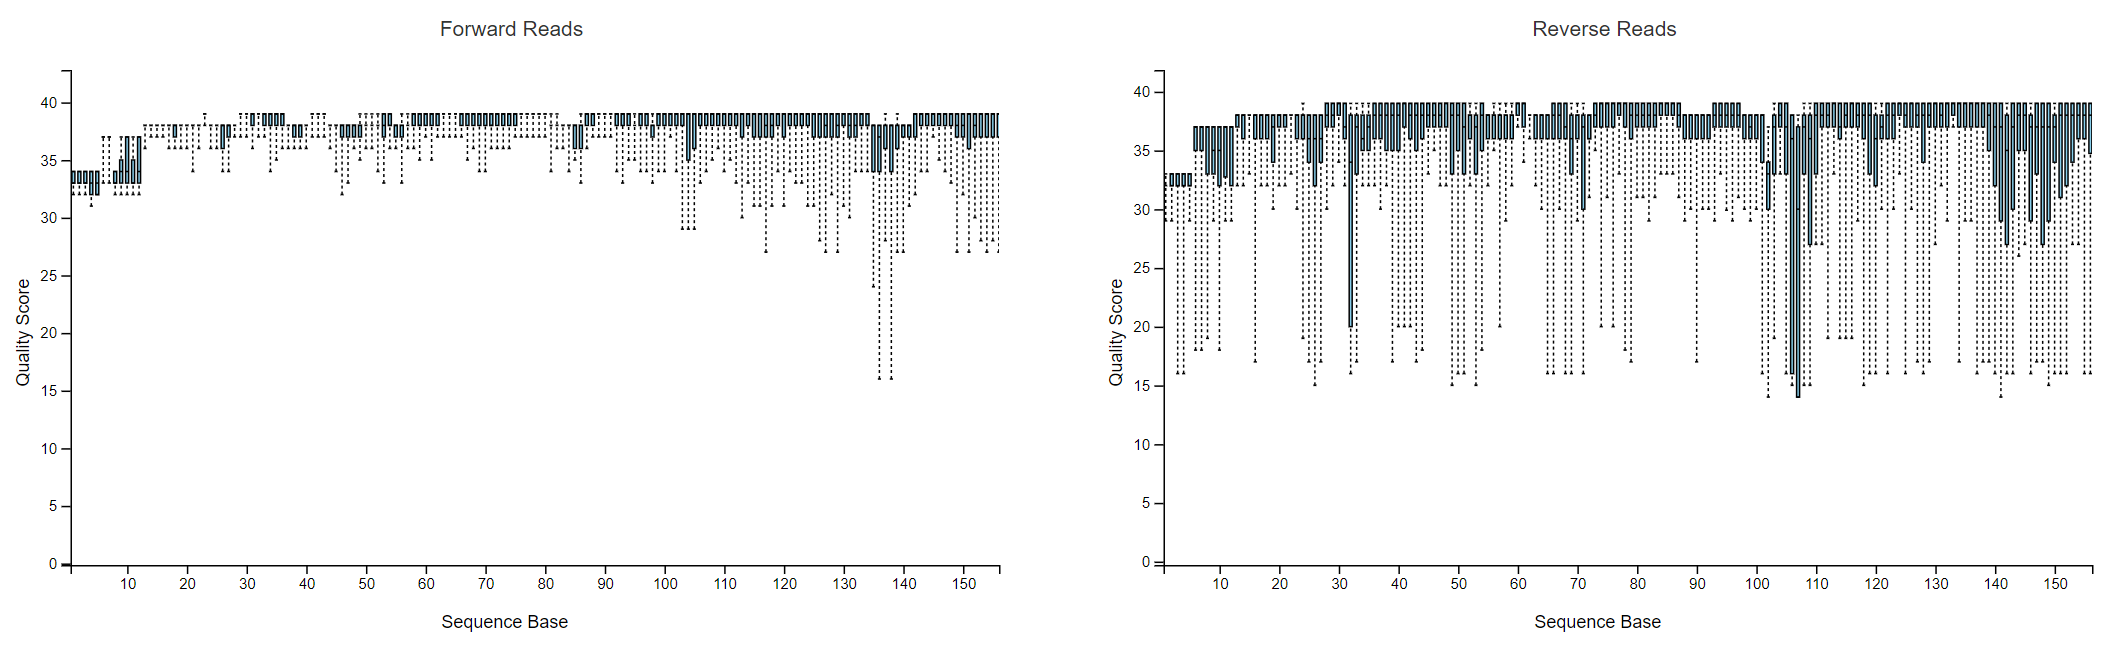

Qualities look good!

In [ ]:
cd 16S_Bacteria_515f-806R

In [ ]:
qiime dada2 denoise-paired \
	--i-demultiplexed-seqs reads/16S-demux.qza \
 	--p-trim-left-f 0 \
 	--p-trim-left-r 0 \
 	--p-trunc-len-f 0 \
 	--p-trunc-len-r 0 \
	--p-n-threads 4 \
	--verbose \
 	--o-table data/QIIME2_output/Grapevine-16S-table.qza \
 	--o-representative-sequences data/QIIME2_output/Grapevine-16S-rep-seq.qza \
 	--o-denoising-stats data/QIIME2_output/Grapevine-16S-DADA2-stats.qza

In [ ]:
cd data/QIIME2_output

In [ ]:
qiime metadata tabulate \
    --m-input-file Grapevine-16S-rep-seq.qza \
    --o-visualization Grapevine-16S-rep-seq.qzv

In [ ]:
qiime feature-table summarize \
    --i-table Grapevine-16S-table.qza \
    --o-visualization Grapevine-16S-table.qzv

### Assign taxonomy using a naive bayesian classifier against the SILVA 138 v4 database:

In [ ]:
qiime feature-classifier classify-sklearn \
	--i-classifier silva-138-99-classifier-515-806.qza \
	--i-reads Grapevine-16S-rep-seq.qza \
	--o-classification Grapevine-16S-SILVA-138.qza \
    --p-n-jobs 24

In [ ]:
qiime metadata tabulate \
    --m-input-file Grapevine-16S-SILVA-138.qza \
    --o-visualization Grapevine-16S-SILVA-138.qzv

### Tidy Table and Filtering

In [ ]:
qiime feature-table filter-samples \
  	--i-table Grapevine-16S-table.qza \
  	--m-metadata-file metadata/Grapevine-16S-metadata_tidy.tsv \
  	--o-filtered-table Grapevine-16S-table_tidy.qza

Run 'Decontam.R' code in RStudio for 'contaminant_asvs.tsv' file.

In [ ]:
qiime feature-table filter-features \
  	--i-table Grapevine-16S-table_tidy.qza \
  	--p-exclude-ids \
  	--m-metadata-file Decontam_output/contaminant_asvs.tsv \
  	--o-filtered-table table1.qza && \

echo 'Done Table 1' && \
# Remove Control Samples

qiime feature-table filter-samples \
  	--i-table table1.qza \
  	--m-metadata-file metadata/Grapevine-16S-metadata_nocontrols.tsv \
  	--o-filtered-table table2.qza && \

echo 'Done Table 2' && \
# Remove ASVs With <10 Seqs

qiime feature-table filter-features \
  	--i-table table2.qza \
  	--p-min-frequency 10 \
  	--o-filtered-table table3.qza && \

echo 'Done Table 3' && \
# Remove Chloroplast and Mitochondria reads

qiime taxa filter-table \
 	--i-table table3.qza \
 	--i-taxonomy Grapevine-16S-SILVA-138.qza \
 	--p-exclude mitochondria,chloroplast \
 	--o-filtered-table Grapevine-16S-table_filtered.qza && \

echo 'Done Filtering' && \

rm Grapevine-16S-table_tidy.qza && rm table1.qza && rm table2.qza && rm table3.qza && \

echo 'Directory Cleaned'

### Run alpha-rarefaction analysis to see what a good sampling depth will be:

In [ ]:
qiime diversity alpha-rarefaction \
--i-table Grapevine-16S-table_filtered.qza \
--m-metadata-file metadata/Grapevine-16S-metadata_nocontrols.tsv \
--o-visualization table-rarefaction.qzv \
--p-min-depth 350 \
--p-max-depth 5000

Rarefaction Plot:

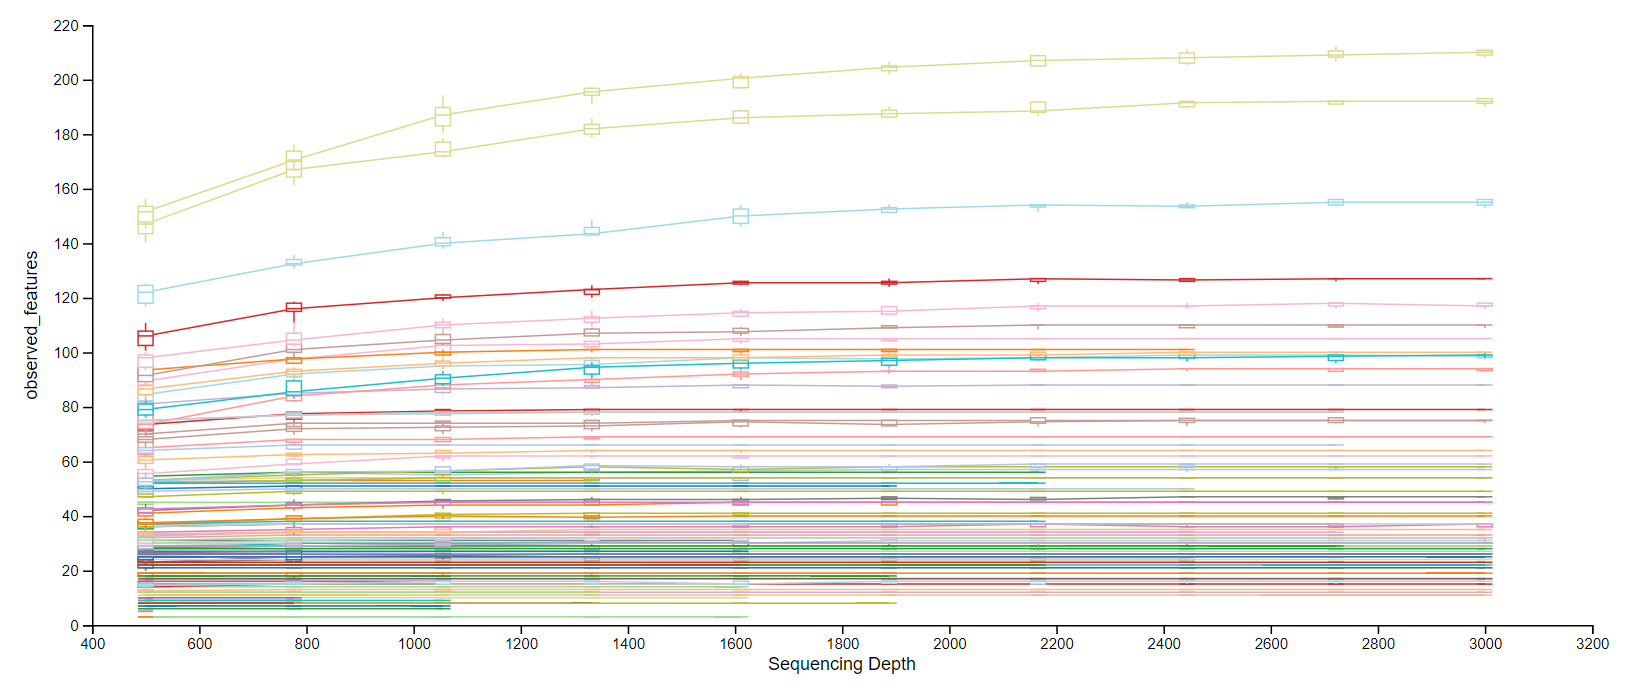

Diversity seems to plateau quickly, likely due to low number of features. PMA treated samples also appear to have less overall features. Cut off marked at sequencing depth of 518. This omits 31 samples.

Rarefaction Plot for PMA+/- Groups:

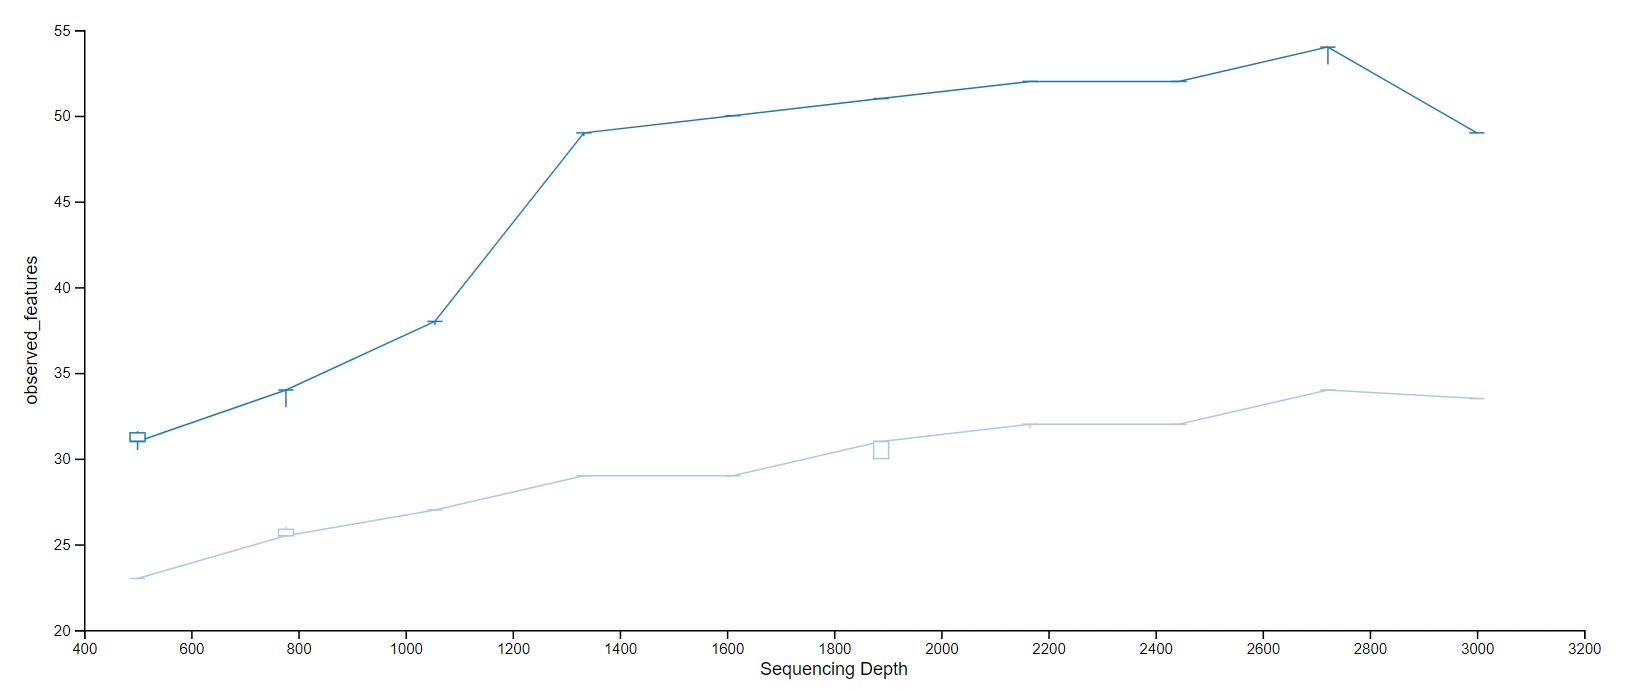

### Supplementary Fig 5: Feature Volatility Plot

#### q2Longitudinal

First, filter table so only PMA treated samples remain.

In [ ]:
cd QIIME2_output

In [ ]:
qiime feature-table filter-samples \
  	--i-table Grapevine-16S-table_filtered.qza \
  	--m-metadata-file metadata/Grapevine-16S-metadata_pma.tsv \
  	--o-filtered-table Grapevine-16S-table_pma.qza

Now, collapse the Table file with the Taxonomy file and run feature-volatility script.

In [ ]:
qiime taxa collapse \
	--i-table Grapevine-16S-table_pma.qza \
	--i-taxonomy Grapevine-16S-SILVA-138.qza \
	--p-level 6 \
	--o-collapsed-table Grapevine-16S-taxtable_pma.qza

Note: The directory 'q2Longitudinal' should not exist prior to running the following script:

In [ ]:
qiime longitudinal feature-volatility \
	--i-table Grapevine-16S-taxtable_pma.qza \
	--m-metadata-file metadata/Grapevine-16S-metadata_pma.tsv \
	--p-state-column day \
	--p-individual-id-column studyid \
	--p-n-estimators 10 \
	--p-random-state 17 \
	--output-dir q2Longitudinal

Output file 'volatility.qzv' 

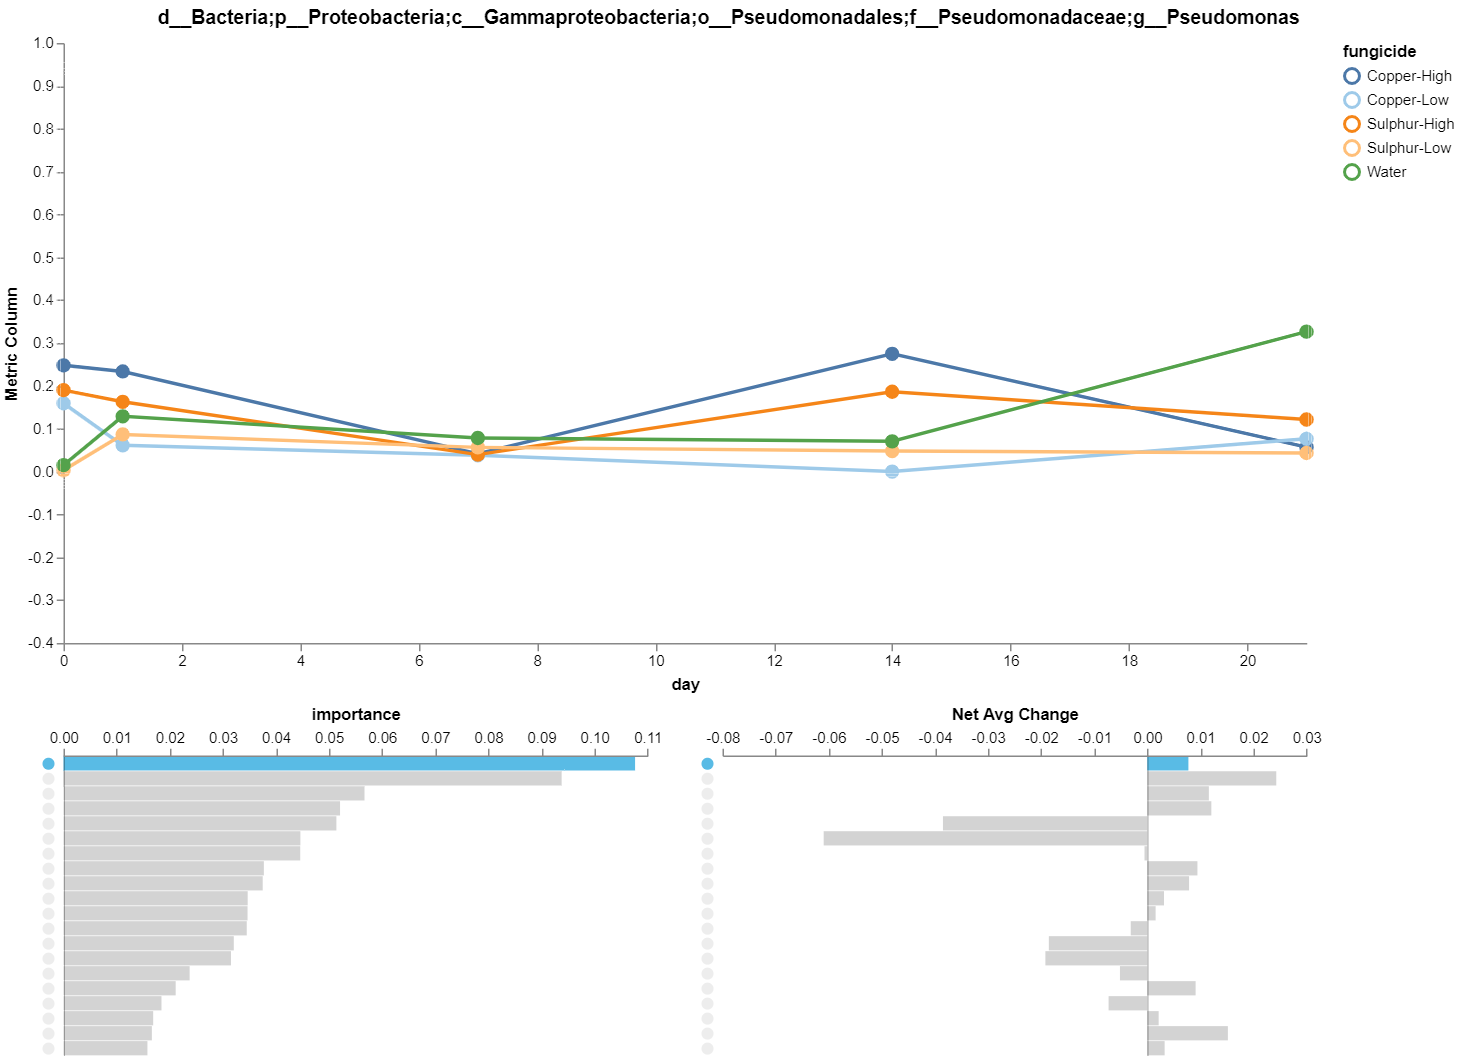

Plot showing changes to features assigned to the genus 'Pseudomonas' which had the highest importance score. Net average change is also shown. Feature list is truncated to show only the top 20 most important features.